In [27]:
print("calibrate camera")

calibrate camera


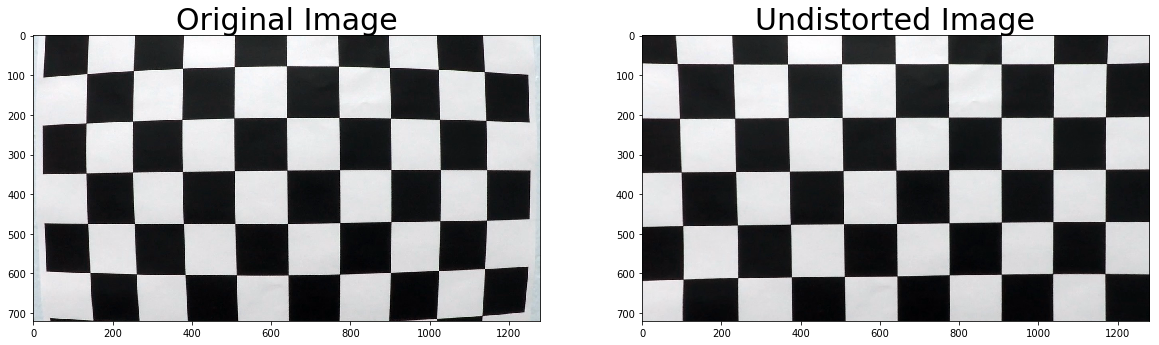

In [83]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle



images = glob.glob('./camera_cal/calibration*.jpg')
test_img = cv2.imread('./camera_cal/calibration1.jpg')


#objp is x,y,z 
objpoints = []
imgpoints = []

#objp is 2D??
objp=np.zeros((6*9,3), np.float32)

objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)


for fname in images:
	img = mpimg.imread(fname)

	gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

	ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

	if ret == True:
		imgpoints.append(corners)
		objpoints.append(objp)

		img = cv2.drawChessboardCorners(img, (9,6), corners, ret)

img_size = (img.shape[1], img.shape[0])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(test_img, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_cal/wide_dist_pickle.p", "wb" ) )
# #dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# # Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(test_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

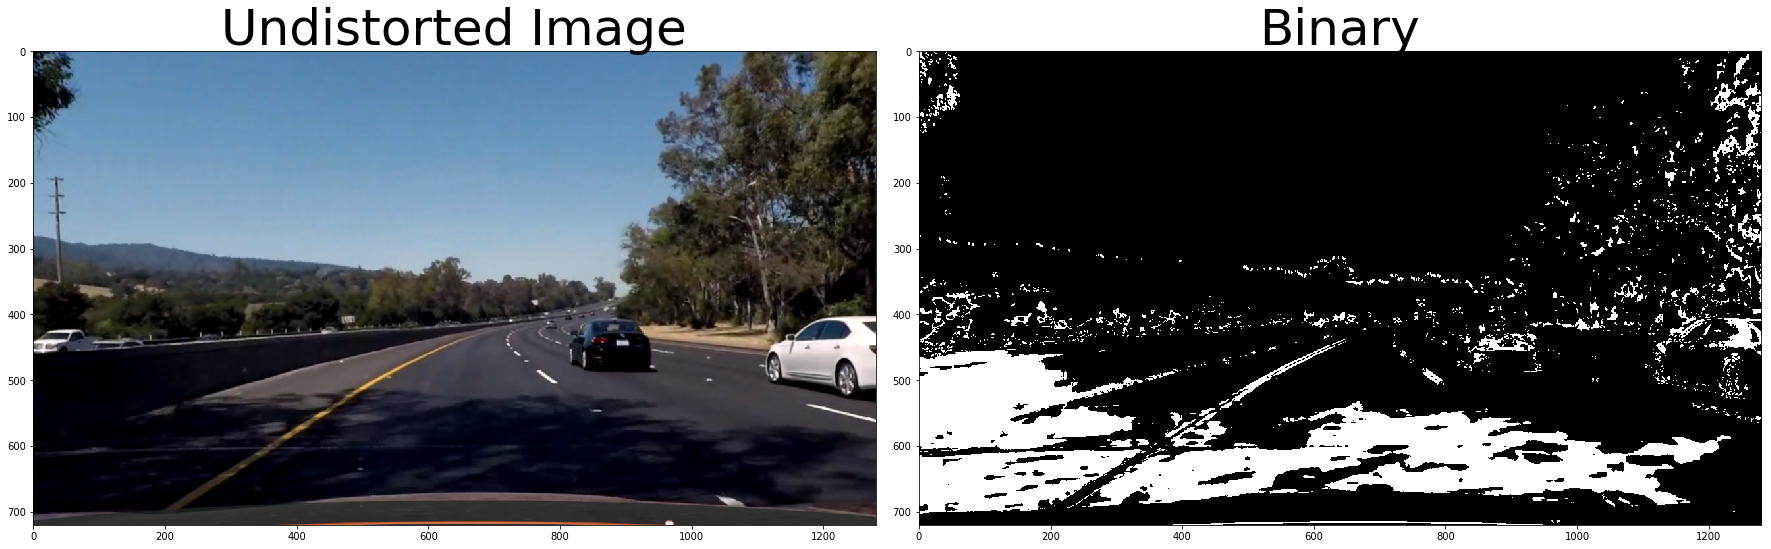

In [231]:
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
%matplotlib inline 

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

    # Return the binary image
    return binary_output


# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    # Convert to grayscale
#    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output


def pipeline(img):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HLS).astype(np.float)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    red = img[:,:,2]
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]


    s_sobel = abs_sobel_thresh(s_channel,orient='x',thresh=(10,100))
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= 200) & (s_channel <= 255)] = 1
    
    r_binary=np.zeros_like(red)
    r_binary[(s_channel >= 150) & (s_channel <= 255)] = 1
    
    ksize = 9 # Choose a larger odd number to smooth gradient measurements
    gradx = abs_sobel_thresh(gray, orient='x', sobel_kernel=ksize, thresh=(50, 100))
    grady = abs_sobel_thresh(gray, orient='y', sobel_kernel=ksize, thresh=(50, 100))
    mag_binary = mag_thresh(gray, sobel_kernel=ksize, mag_thresh=(50, 200))
    dir_binary = dir_threshold(gray, sobel_kernel=ksize, thresh=(0.75, 1.3))
    
    
    
    combined = np.zeros_like(gray)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (s_binary == 1) | r_binary==1 ] = 1
#    combined[(s_binary ==1) | (r_binary==1)] = 1
    #color_binary = np.dstack((combined, s_binary, np.zeros_like(s_binary)))
    gray_binary = combined
    

    return gray_binary
    

dist_pickle = pickle.load( open( "./camera_cal/wide_dist_pickle.p", "rb" ) )

mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
# Choose a Sobel kernel size


#test_image = cv2.imread('./test_images/test1.jpg')
test_image = cv2.imread('./debug4.png')

undist_img = cv2.undistort(test_image, mtx, dist, None, mtx)

lane_img = pipeline(undist_img)

#cv2.imwrite('test.png', scale_back)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(undist_img, cv2.COLOR_BGR2RGB))
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(lane_img, cmap='gray')
ax2.set_title('Binary', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)



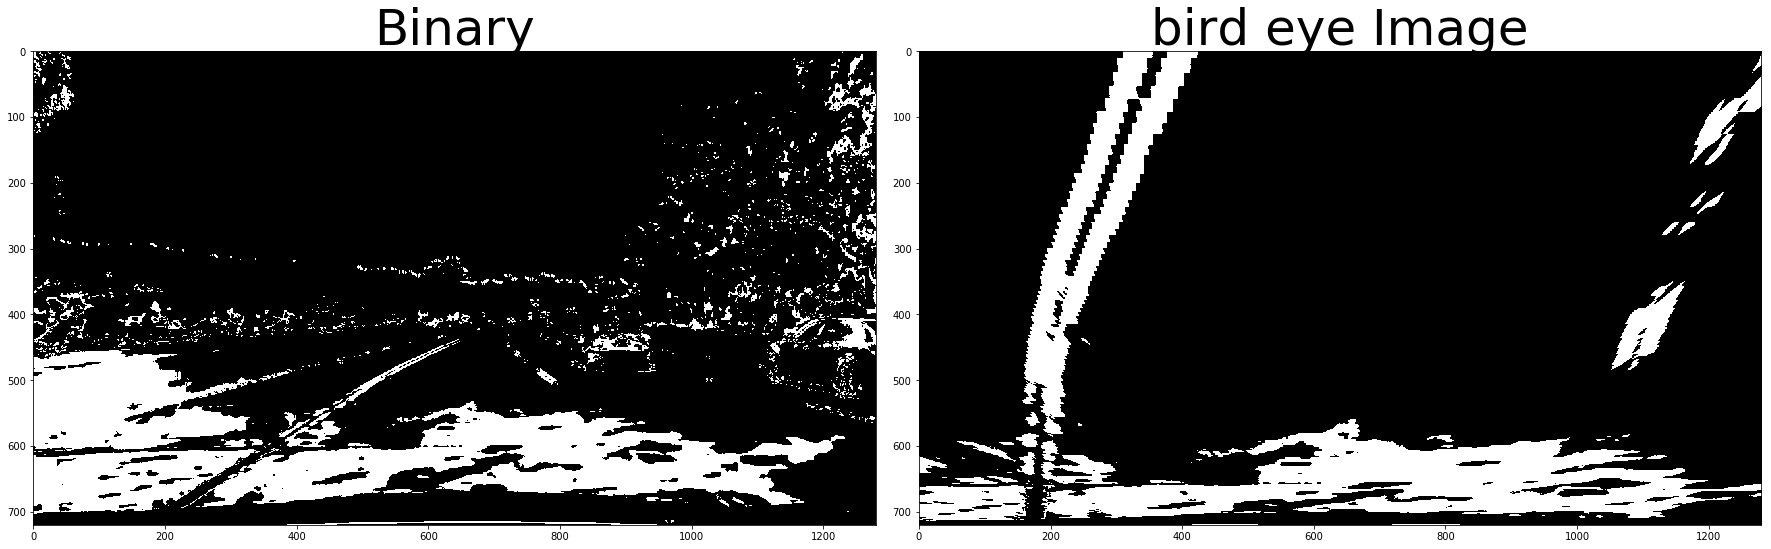

In [232]:
def warp_bird(img):      
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    
    #I tried many values and the final one is from another Udacity student:
    #https://github.com/chrisgundling/Udacity-P4-AdvancedLaneLines/blob/master/P4-AdvancedLanes-Tuning.ipynb
    # Four Source Points
    src = np.float32(
        [[580, 460],
         [200, 720],
         [706, 460],
         [1140, 720]])
    
    # Four Destination Points
    dst = np.float32(
        [[200, 100],
         [200, 720],
         [1040, 100],
         [1040, 720]])
    
    M = cv2.getPerspectiveTransform(src, dst)
    minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    # Return the resulting image and matrix
    return warped, minv


binary_warped, minv = warp_bird(lane_img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(lane_img,cmap='gray')
ax1.set_title('Binary', fontsize=50)
ax2.imshow(binary_warped,cmap='gray')
ax2.set_title('bird eye Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

1. Sliding Window


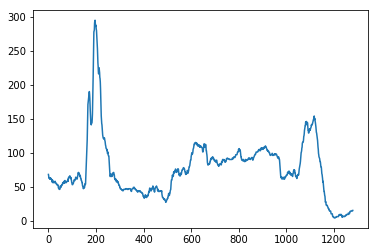

In [233]:
histogram = np.sum(binary_warped[(int)(binary_warped.shape[0]/2):,:], axis=0)
plt.plot(histogram)

(720, 1280)


(720, 0)

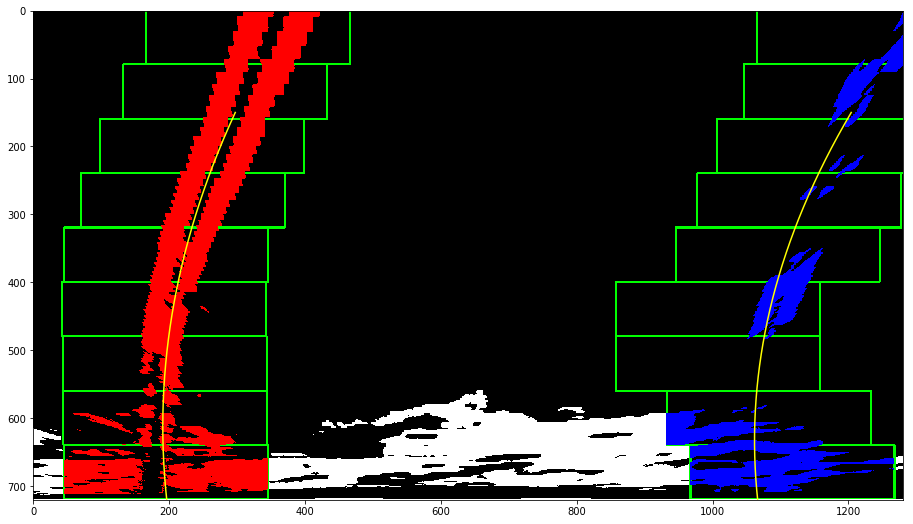

In [253]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
print(binary_warped.shape)


def window(binary_warped, avg_left_fit, avg_right_fit):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[(int)(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 150
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if avg_left_fit != None and avg_right_fit != None:
        left_fit = left_fit*0.2+avg_left_fit*0.8
        right_fit=right_fit*0.2+avg_right_fit*0.8


    # Generate x and y values for plotting
    ploty = np.linspace(150, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return out_img, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, left_fit, right_fit, leftx, lefty,\
            rightx, righty

out_img, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, left_fit, right_fit, \
leftx, lefty, rightx, righty = window(binary_warped, None, None) 

nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.figure(figsize=(24, 9))
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [254]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "binary_warped")
# It's now much easier to find line pixels!
def margin_search(binary_warped,left_fit, right_fit, margin, avg_left_fit, avg_right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if avg_left_fit != None and avg_right_fit != None:
        left_fit = left_fit*0.2+avg_left_fit*0.8
        right_fit = right_fit*0.2+avg_right_fit*0.8    
    # Generate x and y values for plotting
    ploty = np.linspace(150, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    
    return  left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit

left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit = margin_search(binary_warped, left_fit, right_fit, 100, None, None)     

(720, 0)

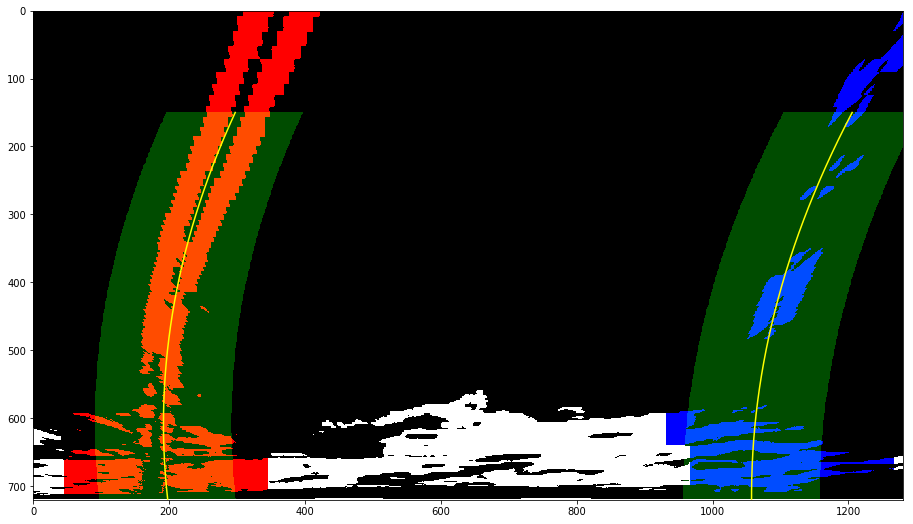

In [255]:
margin = 100
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.figure(figsize=(24, 9))
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

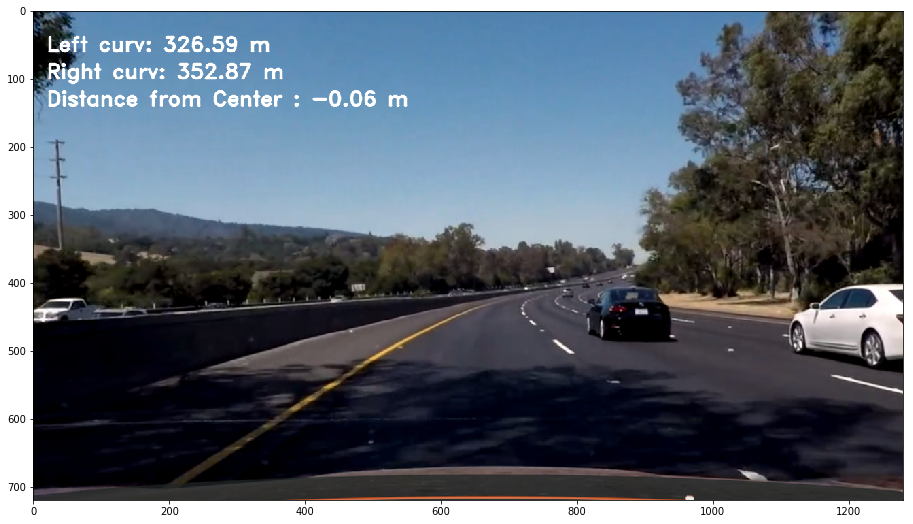

In [256]:

def cal_cur(img, lefty, leftx, righty, rightx):
    img = np.copy(img)
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension

    lefty=lefty*ym_per_pix;
    leftx=leftx*xm_per_pix;

    righty=righty*ym_per_pix;
    rightx=rightx*xm_per_pix;
    y_eval = np.max(lefty)
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty, leftx, 2)
    right_fit_cr = np.polyfit(righty, rightx, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters

    
    left_lane = left_fit[0]*img.shape[0]**2 + left_fit[1]*img.shape[0] + left_fit[2] 
    right_lane = right_fit[0]*img.shape[0]**2 + right_fit[1]*img.shape[0] + right_fit[2]
    car = (result.shape[1] / 2) * xm_per_pix
    lane_center = ((left_lane + right_lane) / 2) * xm_per_pix
    dist = lane_center-car
    
    font = cv2.FONT_HERSHEY_DUPLEX
    cv2.putText(img,'Left curv: %.2f m'%(left_curverad),(20,60), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'Right curv: %.2f m'%(right_curverad),(20,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(img,'Distance from Center : %.2f m'%(dist),(20,140), font, 1,(255,255,255),2,cv2.LINE_AA)
    return img
    
ret = cal_cur(undist_img, lefty, leftx, righty, rightx)
plt.figure(figsize=(24, 9))
plt.imshow(cv2.cvtColor(ret, cv2.COLOR_BGR2RGB))
           

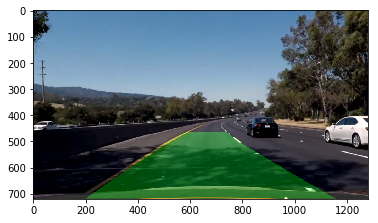

In [257]:
def mapback(binary_warped, undist_img, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, minv, (undist_img.shape[1], undist_img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_img, 1, newwarp, 0.3, 0)
    return result

plt.imshow( cv2.cvtColor(mapback(binary_warped, undist_img, left_fitx, right_fitx, ploty), cv2.COLOR_BGR2RGB))

In [271]:
import random

left_fit=[]
right_fit=[]
use_window=1

hist_l=[]
hist_r=[]

def get_avg():
    if len(hist_l) < 5: 
        return None, None
    else:
        avg_l=(hist_l[-5]+hist_l[-4]+hist_l[-3]+hist_l[-2]+hist_l[-1])/5
        avg_r = (hist_r[-5]+hist_r[-4]+hist_r[-3]+hist_r[-2]+hist_r[-1])/5

    while len(hist_l) > 5:
        hist_l.pop(0)
    return avg_l, avg_r

def process_image(image):
    global left_fit
    global right_fit
    global use_window
    
    undist_img = cv2.undistort(image, mtx, dist, None, mtx)
    lane_img = pipeline(undist_img)
    binary_warped, minv = warp_bird(lane_img)
    
    avg_l, avg_r = get_avg()
    


    if use_window==1:
        img, left_lane_inds, right_lane_inds, left_fitx, right_fitx, ploty, left_fit, right_fit, \
            leftx, lefty, rightx, righty = window(binary_warped, avg_l, avg_r) 
        
    else:
        left_fitx, right_fitx, ploty, leftx, lefty, rightx, righty, left_fit, right_fit\
                     = margin_search(binary_warped, left_fit, right_fit, 100, avg_l, avg_r)         
    use_window = random.choice([True, False])
            
    hist_l.append(left_fit)
    hist_r.append(right_fit)

    result = mapback(binary_warped, undist_img, left_fitx, right_fitx, ploty)
    result = cal_cur(result, lefty, leftx, righty, rightx)
    

    return result

In [272]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

output_clip = 'p4_result.mp4'
input_clip = VideoFileClip("project_video.mp4")
clip=input_clip.subclip(0,51)
clip = clip.fl_image(process_image)
%time clip.write_videofile(output_clip, audio=False)

[MoviePy] >>>> Building video p4_result.mp4
[MoviePy] Writing video p4_result.mp4







  0%|          | 0/1276 [00:00<?, ?it/s]




  0%|          | 1/1276 [00:00<07:50,  2.71it/s]




  0%|          | 2/1276 [00:00<07:54,  2.68it/s]




  0%|          | 3/1276 [00:01<07:42,  2.75it/s]




  0%|          | 4/1276 [00:01<07:25,  2.86it/s]




  0%|          | 5/1276 [00:01<07:20,  2.89it/s]




  0%|          | 6/1276 [00:02<07:22,  2.87it/s]




  1%|          | 7/1276 [00:02<07:20,  2.88it/s]




  1%|          | 8/1276 [00:02<07:07,  2.97it/s]




  1%|          | 9/1276 [00:03<07:04,  2.98it/s]




  1%|          | 10/1276 [00:03<06:59,  3.02it/s]




  1%|          | 11/1276 [00:03<06:48,  3.10it/s]




  1%|          | 12/1276 [00:04<06:53,  3.06it/s]




  1%|          | 13/1276 [00:04<06:46,  3.11it/s]




  1%|          | 14/1276 [00:04<06:43,  3.13it/s]




  1%|          | 15/1276 [00:04<06:43,  3.13it/s]




  1%|▏         | 16/1276 [00:05<06:55,  3.03it/s]




  1%|▏         | 17/1276 [00:05<06:52,  3.05it/s]




  1%|▏         | 18/1276 [00:06<07:25,  2

[MoviePy] Done.
[MoviePy] >>>> Video ready: p4_result.mp4 

CPU times: user 17min 37s, sys: 26.7 s, total: 18min 4s
Wall time: 7min 12s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))